# Lab 3
Danila Danko, Andrey Linyushin

## 1. Motor simulation

### 1.1

In [443]:
import numpy as np
from scipy.integrate import solve_ivp

In [444]:
milli = 10 ** (-3)
kilo = 1 / milli
centi = 10 ** (-2)
rps = 2*np.pi/60
# value from sheet : SI value
mdata = {
    "nominal voltage, V": 12,
    "no load speed, rpm": 12100 * rps,
    "no load current, mA": 155 * milli,
    "nominal speed, rpm": 8040 * rps,
    "nominal torque, mNm": 10.2 * milli,
    "nominal current, A": 1.25,
    "stall torque, mNm": 31.3 * milli,
    "stall current, A": 3.47,
    "max. efficiency, %": 64 * centi,
    "terminal resistance, omega": 3.46,
    "terminal inductance, mH": 0.121 * milli,
    "torque constant, mNm/A": 9.02 * milli,
    "speed constant, rpm/V": 1 / (1060 * rps),
    "speed/torque gradient, rpm/mNm": 406 * rps / milli,
    "mechanical time constant, ms": 9.56 * milli,
    "rotor inertia, g*cm^2": 2.25 * milli * centi ** 2,
}

In [445]:
L = mdata["terminal inductance, mH"]
V = mdata["nominal voltage, V"]
K_b = mdata["speed constant, rpm/V"]
R = mdata["terminal resistance, omega"]
K_m = mdata["torque constant, mNm/A"]
J = mdata["rotor inertia, g*cm^2"]
tau_l = 0
B_m = 0

In [446]:
t1 = np.arange(
    start = 0, 
    stop = 100 * milli,
    step = 1 * milli * milli
)

In [447]:
x0 = [0, 0, 0]

In [448]:
def solve_motor(
    y0=x0, t_eval=t1, L=L, V=V, K_b=K_b, R=R, J=J, K_m=K_m, tau_l=tau_l, B_m=B_m
):
    """solver for motor system

    ----------
    ### Parameters
      `y0` : `np.array`
          initial values
      `t` : `np.array`
          time coordinates
      `args` : `[float, float, float]`
          `L` - terminal inductance
          `V` - nominal voltage
          `K_b` - speed constant
          `R` - terminal resistance
          `K_m` - torque constant
          `tau_l` - load torque
          `B_m` - friction coefficient


    -------
    ### Returns
      `np.array`
          solution to the system
    """
    B = np.array([V / L, 0, -tau_l / J])
    A = np.array([[-R / L, 0, -K_b / L], [0, 0, 1], [K_m / J, 0, -B_m / J]])
    
    def state_space(t, y):
        return A.dot(y) + B

    t_span = (t_eval[0], t_eval[-1])
    return solve_ivp(fun=state_space, y0=y0, t_span=t_span, t_eval=t_eval)


In [449]:
from utils import solve_list, plot_sol

In [450]:
sol = solve_list([[solve_motor,{"t_eval": t1}]])[0]

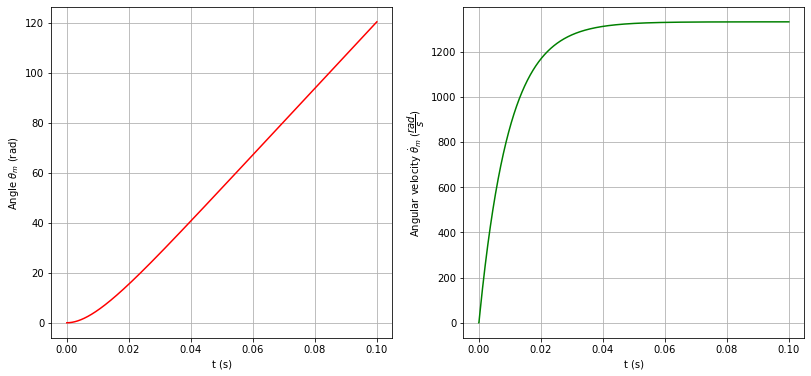

In [451]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Angle $\\theta_m$ (rad)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[1], "color": "r"},
            ],
        },
        {
            "xlabel": "t (s)",
            "ylabel": "Angular velocity $\\dot \\theta_m$ ($\\dfrac{rad}{s}$)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[2], "color": "g"},
            ],
        },
    ]
)

### 1.2

In [452]:
theta_dot = sol.y[2]
theta_dot_nl = theta_dot[-1]
print(f"No load speed (rpm):\n simulated: {theta_dot_nl / rps} \n theoretical: {mdata['no load speed, rpm'] / rps}")

No load speed (rpm):
 simulated: 12719.640010713814 
 theoretical: 12100.0


In [453]:
bound = 0.632 * np.abs(theta_dot_nl)
t_m_measured = sol.t[np.abs(theta_dot) <= bound][-1]

In [454]:
print(f"Time constant (ms):\n simulated: {t_m_measured / milli:0.7f} \n theoretical: {mdata['mechanical time constant, ms'] / milli:0.7f}")

Time constant (ms):
 simulated: 9.5760000 
 theoretical: 9.5600000


## 2. PD control

### 2.1

In [455]:
K_p=100
K_d=1
theta_d=100
theta_dot_d=0

In [456]:
voltage = []

def solve_motor_pd(
    y0=x0,
    t_eval=t1,
    L=L,
    V=V,
    K_b=K_b,
    R=R,
    J=J,
    K_m=K_m,
    tau_l=tau_l,
    B_m=B_m,
    K_p=K_p,
    K_d=K_d,
    theta_d=theta_d,
    theta_dot_d=theta_dot_d,
):
    """solver for motor system

    ----------
    ### Parameters
      `y0` : `np.array`
          initial values
      `t` : `np.array`
          time coordinates
      `args` : `[float, float, float]`
          `L` - terminal inductance
          `V` - nominal voltage
          `K_b` - speed constant
          `R` - terminal resistance
          `K_m` - torque constant
          `tau_l` - load torque
          `B_m` - friction coefficient
          `K_p` - proportional constant
          `K_d` - derivative constant

    -------
    ### Returns
      `np.array`
          solution to the system
    """
    B = np.array([V / L, 0, -tau_l / J])
    A = np.array([[-R / L, 0, -K_b / L], [0, 0, 1], [K_m / J, 0, -B_m / J]])
    K = np.array([K_p, K_d])
    x_d = np.array([theta_d, theta_dot_d])

    def state_space(t, y):
        e = x_d - y[1:]
        u = K.dot(e)
        global voltage
        voltage += [[t, B.dot(u)[0] * L]]
        return A.dot(y) + B.dot(u)

    t_span = (t_eval[0], t_eval[-1])
    return solve_ivp(fun=state_space, y0=y0, t_span=t_span, t_eval=t_eval)


In [457]:
sol = solve_list([[solve_motor_pd,{"t_eval": t1}]])[0]

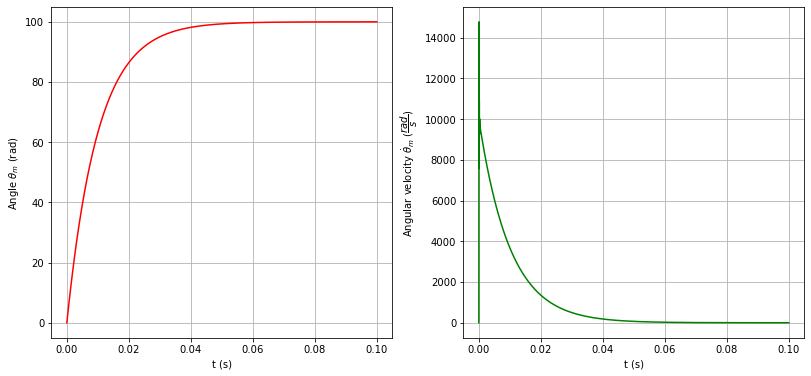

In [458]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Angle $\\theta_m$ (rad)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[1], "color": "r"},
            ],
        },
        {
            "xlabel": "t (s)",
            "ylabel": "Angular velocity $\\dot \\theta_m$ ($\\dfrac{rad}{s}$)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[2], "color": "g"},
            ],
        },
    ]
)

### 2.2

In [459]:

err_bound = 2 * centi * theta_d
theta = sol.y[1]
t_settling = sol.t[np.abs(theta - theta_d) >= err_bound][-1]

In [460]:
print(f"Settling time (ms): {t_settling / milli}")

Settling time (ms): 39.12799999999999


In [461]:
overs = theta[theta - theta_d >= 0.]
overshoot = 0 if len(overs) == 0 else (np.amax(overs) - theta_d) / theta_d

In [462]:
print(f"Overshoot (%): {overshoot}")

Overshoot (%): 0


In [463]:
ss_error = theta_d - theta[-1]

In [464]:
print(f"Steady-state error (rad): {ss_error}")

Steady-state error (rad): 0.004544784066311536


In [465]:
max_speed = np.amax(sol.y[2])

In [466]:
print(f"Max speed (rpm): {max_speed / rps}")

Max speed (rpm): 141143.3169200812


### 2.3

In [467]:
voltage = np.array(voltage).T

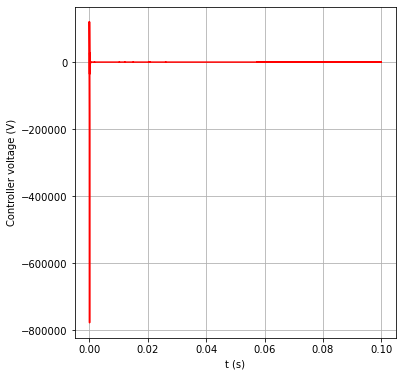

In [468]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Controller voltage (V)",
            "x": voltage[0],
            "graphs": [
                {"y": voltage[1], "color": "r"},
            ],
        },
    ]
)

### 2.4

In [485]:
def solve_motor_pd_saturated(
    y0=x0,
    t_eval=t1,
    L=L,
    V=V,
    K_b=K_b,
    R=R,
    J=J,
    K_m=K_m,
    tau_l=tau_l,
    B_m=B_m,
    K_p=K_p,
    K_d=K_d,
    theta_d=theta_d,
    theta_dot_d=theta_dot_d,
):
    """solver for motor system

    ----------
    ### Parameters
      `y0` : `np.array`
          initial values
      `t` : `np.array`
          time coordinates
      `args` : `[float, float, float]`
          `L` - terminal inductance
          `V` - nominal voltage
          `K_b` - speed constant
          `R` - terminal resistance
          `K_m` - torque constant
          `tau_l` - load torque
          `B_m` - friction coefficient
          `K_p` - proportional constant
          `K_d` - derivative constant

    -------
    ### Returns
      `np.array`
          solution to the system
    """
    B = np.array([V / L, 0, -tau_l / J])
    A = np.array([[-R / L, 0, -K_b / L], [0, 0, 1], [K_m / J, 0, -B_m / J]])
    K = np.array([K_p, K_d])
    x_d = np.array([theta_d, theta_dot_d])

    def state_space(t, y):
        e = x_d - y[1:]
        u = K.dot(e)
        u = np.sign(u) * min(np.abs(u), V)
        return A.dot(y) + B.dot(u)

    t_span = (t_eval[0], t_eval[-1])
    return solve_ivp(fun=state_space, y0=y0, t_span=t_span, t_eval=t_eval)


In [486]:
sol = solve_list([[solve_motor_pd_saturated,{"t_eval": t1}]])[0]

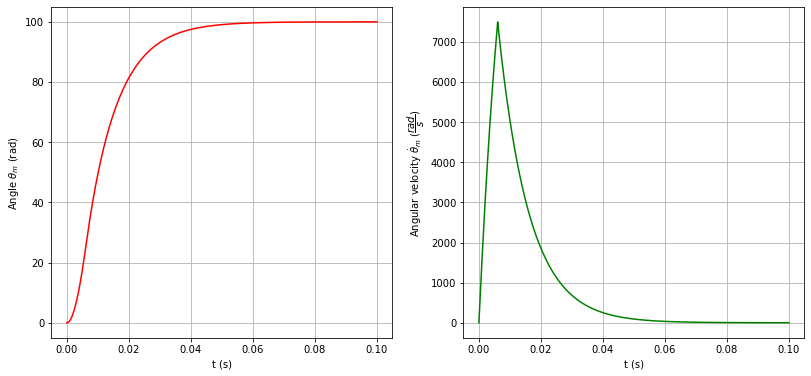

In [487]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Angle $\\theta_m$ (rad)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[1], "color": "r"},
            ],
        },
        {
            "xlabel": "t (s)",
            "ylabel": "Angular velocity $\\dot \\theta_m$ ($\\dfrac{rad}{s}$)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[2], "color": "g"},
            ],
        },
    ]
)

### 2.2

In [488]:

err_bound = 2 * centi * theta_d
theta = sol.y[1]
t_settling = sol.t[np.abs(theta - theta_d) >= err_bound][-1]

In [489]:
print(f"Settling time (ms): {t_settling / milli}")

Settling time (ms): 42.318


In [490]:
overs = theta[theta - theta_d >= 0.]
overshoot = 0 if len(overs) == 0 else (np.amax(overs) - theta_d) / theta_d

In [491]:
print(f"Overshoot (%): {overshoot}")

Overshoot (%): 0


In [492]:
ss_error = theta_d - theta[-1]

In [493]:
print(f"Steady-state error (rad): {ss_error}")

Steady-state error (rad): 0.006252529701214371


In [494]:
max_speed = np.amax(sol.y[2])

In [495]:
print(f"Max speed (rpm): {max_speed / rps}")

Max speed (rpm): 71633.5668965593
